# Customer Analysis - Final Code and Notes

In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import engine
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [2]:
# First, I will connect to the data and create a dataframe

conn_string = r"postgresql://masterschool-analyst:pa84cc0d01e9b241460abdf838bb34f5932c9473dca571b56fcb13dd3023a62e0@ec2-52-4-84-108.compute-1.amazonaws.com:5432/da541q56oobji4"
connection = engine.create_engine(conn_string)

In [5]:
# I will transfer the query used to create the filtered CTE in SQL here to create a subset of the relevant data for analysis.
# I will have to use %% for my ilike conditions since % is used by Python string formatting

cte_query = """
  SELECT 
    order_id, 
    partner_id AS operator_id, 
    partner_name AS operator_name, 
    status, 
    m.source, 
    fullname, 
    email AS customer_email, 
    company_name, 
    confirmation_id, 
    space_id, 
    space_name, 
    created_at, 
    promotion_code, 
    total_price AS final_price, 
    --not usd,  sub_total + tax_amount, sub_total=order_line_item_total_price
    ABS(discounted_amount) AS discounted_amount, 
    --not usd
    total_price_in_usd AS final_price_usd, 
    --amount transacted through Flexspace
    ABS(ROUND(
      discounted_amount * to_usd_rate, 2
    )) AS discounted_amount_usd, 
    ROUND(
      (
        total_price_in_usd + ABS(discounted_amount * to_usd_rate)
      ), 
      2
    ) AS original_price_usd, 
    processing_fee_in_usd, 
    to_usd_rate, 
    location_id, 
    location_name_en, 
    location_time_zone, 
    country, 
    m.state, 
    city, 
    order_line_item_id, 
    orderable_type, 
    orderable_id, 
    order_line_item_details, 
    access_id, 
    booking_product_type, 
    product_type_id, 
    add_on_days_to_expire, 
    capacity, 
    booking_id, 
    start_date, 
    end_date, 
    date, 
    quantity, 
    last_refresh 
  FROM 
    mat_orders AS m 
  WHERE created_at < '2023-07-01'
    AND status = 'paid' 
    AND email NOT IN (
      SELECT 
        email 
      FROM 
        mat_orders 
      WHERE 
        1 = 1 
        AND (
          company_name ILIKE '%%test%%'
          OR fullname ILIKE '%%test%%' 
          OR email ILIKE '%%test%%' 
          OR email ILIKE '%%flexspace%%' 
          OR promotion_code ILIKE '%%test%%'
          OR partner_name ILIKE '%%test%%'
        )
    ) 
    AND m.source IN ('WL', 'FM')
;

"""

filtered_df = pd.read_sql(cte_query, con=conn_string)

In [6]:
pd.set_option('display.max_columns', None)

filtered_df.head()

,order_id,operator_id,operator_name,status,source,fullname,customer_email,company_name,confirmation_id,space_id,space_name,created_at,promotion_code,final_price,discounted_amount,final_price_usd,discounted_amount_usd,original_price_usd,processing_fee_in_usd,to_usd_rate,location_id,location_name_en,location_time_zone,country,state,city,order_line_item_id,orderable_type,orderable_id,order_line_item_details,access_id,booking_product_type,product_type_id,add_on_days_to_expire,capacity,booking_id,start_date,end_date,date,quantity,last_refresh
0,041cac62-1867-453e-a5ea-5d80a54ab149,7041dd96-032c-4284-bb6f-cd48f207b956,Mindspace,paid,WL,Segah Meer,segah@keetro.net,Keetro Labs,754008a9,62e8d0bd-d025-485a-a836-02adf6d32ccd,Mindspace Daily - Ha’Bursa,2021-06-02 05:20:12.325725,SPECIAL521,1067.04,48.0,325.97,14.66,340.63,9.75,0.305490,aae68b56-d19a-4b68-a795-1047ca8748a2,Ramat Gan - Ha’Bursa,Asia/Jerusalem,IL,None,Ramat Gan,359640c3-fa2b-4210-8254-dd67955f9ab5,AddOn,3a05162a-c2c2-47fd-91d0-b1ac10d43144,{'space_id': '62e8d0bd-d025-485a-a836-02adf6d3...,None,access_add_on,1986c53d-96a1-4394-8012-a993b46f6e43,60.0,NaN,None,None,None,None,1.0,2023-07-23 21:15:00.231227+00:00
1,c437542e-7369-4f57-9634-d3d8c906049d,7041dd96-032c-4284-bb6f-cd48f207b956,Mindspace,paid,WL,Mark Bosshard,mark.bosshard1@gmail.com,ipt,163b482a,eb3f2ab3-a890-452e-aae9-099e49454f2f,Mindspace Daily - Dam,2021-11-26 08:11:23.629412,None,30.25,0.0,33.57,0.00,33.57,1.61,1.109830,76fdc9f9-777d-401b-bf05-f1f81c27933a,Amsterdam - Dam,Europe/Amsterdam,NL,None,Amsterdam,afc68bc2-cba4-4229-aa52-eff96dffee1b,Booking,1c23a107-65a9-453a-8367-5e7d81b6f772,"{'days': 1, 'time': None, 'end_date': '2021-11...",None,entire_location,bef677a6-5596-4ca0-a31e-ea2eccb5e959,NaN,1.0,1c23a107-65a9-453a-8367-5e7d81b6f772,2021-11-26,2021-11-26,None,1.0,2023-07-23 21:15:00.231227+00:00
2,9906ceef-5ac6-411c-ac3f-bdc88494f7fd,b6bfa6e9-e780-4b7c-af83-39a63380a709,WeWork Israel,paid,WL,Justin Rohloff,justin@rohloffgroup.co.za,Rohloff,6abd5552,0f197ecc-570f-4bed-b382-9a2b717ce533,Open Workspace Day Pass,2021-11-15 07:18:18.568518,None,374.40,0.0,120.69,0.00,120.69,0.00,0.322369,b2ee7ec8-5c3d-4768-9c47-64fd57d79cc7,WeWork Jerusalem,Asia/Jerusalem,IL,None,Jerusalem,ca946768-159d-41b6-9cd6-c2d9440f7c72,AddOn,afd158c3-900d-482b-b91f-193b25e7963a,{'space_id': '0f197ecc-570f-4bed-b382-9a2b717c...,None,access_add_on,e1b38119-616d-4a17-8dd0-3458369ca4e8,90.0,NaN,None,None,None,None,1.0,2023-07-23 21:15:00.231227+00:00
3,f2da7ed7-00cd-4d85-85b3-a5121fd28202,7041dd96-032c-4284-bb6f-cd48f207b956,Mindspace,paid,WL,Andrei Marcut,andrei@creativegluelab.com,Creative Glue Lab GmbH,4e5e9d5c,138b7e56-61c1-4e9a-9a56-84bae539f131,Mindspace Daily - Uhlandstraße 32 (Ku'damm),2023-04-11 07:40:12.034568,,104.72,0.0,112.69,0.00,112.69,4.69,1.076110,855fa3e4-8382-4fbc-b2f9-d9b0f9a20f57,Berlin - Ku’damm,Europe/Berlin,DE,None,Berlin,a0a9fbae-2575-4e73-b7d6-ec923ad8bfff,AddOn,d2adbe4e-aa1e-484e-af40-60f3fe3abfa8,{'space_id': '138b7e56-61c1-4e9a-9a56-84bae539...,None,access_add_on,1986c53d-96a1-4394-8012-a993b46f6e43,30.0,NaN,None,None,None,None,1.0,2023-07-23 21:15:00.231227+00:00
4,f076ff1f-38d4-45b0-b11c-5113e980d63e,d0db8780-54e4-41c2-b93c-56db16bf4d56,Werqwise,paid,WL,Alyssa Lammers,alammers@acerelocation.com,Ace Relocation Systems,de14b36f,3149a46e-d508-475d-8343-421030c99354,Lounge Day Pass,2022-06-20 21:00:18.986207,None,45.00,0.0,45.00,0.00,45.00,1.61,1.000000,1e7217b4-ea52-4a54-a55c-6262641282ff,Werqwise San Francisco,America/Los_Angeles,US,CA,San Francisco,c9141477-65e1-4feb-8417-f3e38a45c039,Booking,15e95d1c-c769-46f0-a54f-02a430bd1b8f,"{'days': 1, 'time': None, 'daily': {'time': No...",None,entire_location,537ed05a-5508-4e97-aac4-6f01e692ac59,NaN,1.0,15e95d1c-c769-46f0-a54f-02a430bd1b8f,2022-06-29,2022-06-29,None,1.0,2023-07-23 21:15:00.231227+00:00


In [7]:
# access_id can be dropped since this only contains null values

filtered_df = filtered_df.drop(['access_id'], axis=1)

filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22686 entries, 0 to 22685
Data columns (total 40 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   order_id                 22686 non-null  object             
 1   operator_id              22686 non-null  object             
 2   operator_name            22686 non-null  object             
 3   status                   22686 non-null  object             
 4   source                   22686 non-null  object             
 5   fullname                 22686 non-null  object             
 6   customer_email           22686 non-null  object             
 7   company_name             22686 non-null  object             
 8   confirmation_id          22686 non-null  object             
 9   space_id                 22679 non-null  object             
 10  space_name               22679 non-null  object             
 11  created_at               226

## General Customer Overview

This section will be dedicated to finding some general insights about the Flexspace customers. The following questions will be addressed and visualized if needed:

- How many distinct customers are there? Per company?
- Where are customers located? 
- What orderable_types and booking_product_types are customers ordering? What are the total order distribution counts for each type?
- What is the product basket customers are purchasing? What programmatic combinations of products are being ordered by customers?
- What is the distribution of the monetary columns? Are there any outliers, or are these purchases specific to a customer or group, space, etc?

#### How many distinct customers are there?


In [8]:
# How many distinct customers are there? 

filtered_df.customer_email.nunique()

14064

In [10]:
# Quick tidy of company names

# Replace the similar values with 'self-employed' and 'n/a'
# Define the pattern replacements
pattern_replacements = {
    r'.*self.*': 'self-employed',
    r'(?<!\bsourceability \b)\bna\b': 'n/a',
    r'^-$': 'n/a',
    r'(?<!\bbar \b)\bnone\b': 'n/a',
    r'^ $': 'n/a',
    r'^  $': 'n/a'
}


filtered_df['company_name_lower'] = filtered_df['company_name'].str.lower()


for pattern, replacement in pattern_replacements.items():
    filtered_df['company_name_lower'] = filtered_df['company_name_lower'].str.replace(pattern, replacement, regex=True)

    
# Value counts on company_name_lower
filtered_df.company_name_lower.value_counts().head(20)

n/a                        763
self-employed              242
knowledge train             85
augury                      78
ciic pr                     60
videoamp                    52
sharethis                   49
seed                        43
lookiero style uk ltd       42
synerflow b.v.              42
hardskills gmbh             42
razroo ltd                  39
studio werc ltd             39
private                     38
opportunity lab             38
digital republic talent     36
christin nagel              34
modern health               34
ביי וויט בע״מ               34
w wine school               34
Name: company_name_lower, dtype: int64

#### Where are customers located?

In [11]:
# Where are customers located?

# How many countries are in the filtered data, and what frequency of orders does each have? 
#Order frequency per country
filtered_df.country.value_counts()

US    9027
IL    5851
DE    4786
GB    1210
NL     947
PL     570
RO     288
Name: country, dtype: int64

**There are 7 countries in the filtered data:**

1. US (United States)
2. IL (Israel)
3. DE (Germany)
4. GB (Great Britain/United Kingdom)
5. NL (Netherlands)
6. PL (Poland)
7. RO (Romania)

**5 countries were excluded from the original data. This could be due to low order frequencies:**

1. AU (Australia)
2. CA (Canada)
3. MX (Mexico)
4. PT (Portugal)
5. VN (Vietnam)

It could be helpful to inlcude the full names for each country for readability. 

In [12]:
# Mapping dictionary for country codes to country names
country_mapping = {'US': 'United States', 
                   'GB': 'United Kingdom', 
                   'IL': 'Israel', 
                   'NL': 'Netherlands', 
                   'PL':'Poland', 
                   'RO':'Romania',
                   'DE':'Germany'
                  }

# Create a new column with the full country names
filtered_df['country_full'] = filtered_df['country'].map(country_mapping)

# Display the DataFrame
filtered_df.head()

,order_id,operator_id,operator_name,status,source,fullname,customer_email,company_name,confirmation_id,space_id,space_name,created_at,promotion_code,final_price,discounted_amount,final_price_usd,discounted_amount_usd,original_price_usd,processing_fee_in_usd,to_usd_rate,location_id,location_name_en,location_time_zone,country,state,city,order_line_item_id,orderable_type,orderable_id,order_line_item_details,booking_product_type,product_type_id,add_on_days_to_expire,capacity,booking_id,start_date,end_date,date,quantity,last_refresh,company_name_lower,country_full
0,041cac62-1867-453e-a5ea-5d80a54ab149,7041dd96-032c-4284-bb6f-cd48f207b956,Mindspace,paid,WL,Segah Meer,segah@keetro.net,Keetro Labs,754008a9,62e8d0bd-d025-485a-a836-02adf6d32ccd,Mindspace Daily - Ha’Bursa,2021-06-02 05:20:12.325725,SPECIAL521,1067.04,48.0,325.97,14.66,340.63,9.75,0.305490,aae68b56-d19a-4b68-a795-1047ca8748a2,Ramat Gan - Ha’Bursa,Asia/Jerusalem,IL,None,Ramat Gan,359640c3-fa2b-4210-8254-dd67955f9ab5,AddOn,3a05162a-c2c2-47fd-91d0-b1ac10d43144,{'space_id': '62e8d0bd-d025-485a-a836-02adf6d3...,access_add_on,1986c53d-96a1-4394-8012-a993b46f6e43,60.0,NaN,None,None,None,None,1.0,2023-07-23 21:15:00.231227+00:00,keetro labs,Israel
1,c437542e-7369-4f57-9634-d3d8c906049d,7041dd96-032c-4284-bb6f-cd48f207b956,Mindspace,paid,WL,Mark Bosshard,mark.bosshard1@gmail.com,ipt,163b482a,eb3f2ab3-a890-452e-aae9-099e49454f2f,Mindspace Daily - Dam,2021-11-26 08:11:23.629412,None,30.25,0.0,33.57,0.00,33.57,1.61,1.109830,76fdc9f9-777d-401b-bf05-f1f81c27933a,Amsterdam - Dam,Europe/Amsterdam,NL,None,Amsterdam,afc68bc2-cba4-4229-aa52-eff96dffee1b,Booking,1c23a107-65a9-453a-8367-5e7d81b6f772,"{'days': 1, 'time': None, 'end_date': '2021-11...",entire_location,bef677a6-5596-4ca0-a31e-ea2eccb5e959,NaN,1.0,1c23a107-65a9-453a-8367-5e7d81b6f772,2021-11-26,2021-11-26,None,1.0,2023-07-23 21:15:00.231227+00:00,ipt,Netherlands
2,9906ceef-5ac6-411c-ac3f-bdc88494f7fd,b6bfa6e9-e780-4b7c-af83-39a63380a709,WeWork Israel,paid,WL,Justin Rohloff,justin@rohloffgroup.co.za,Rohloff,6abd5552,0f197ecc-570f-4bed-b382-9a2b717ce533,Open Workspace Day Pass,2021-11-15 07:18:18.568518,None,374.40,0.0,120.69,0.00,120.69,0.00,0.322369,b2ee7ec8-5c3d-4768-9c47-64fd57d79cc7,WeWork Jerusalem,Asia/Jerusalem,IL,None,Jerusalem,ca946768-159d-41b6-9cd6-c2d9440f7c72,AddOn,afd158c3-900d-482b-b91f-193b25e7963a,{'space_id': '0f197ecc-570f-4bed-b382-9a2b717c...,access_add_on,e1b38119-616d-4a17-8dd0-3458369ca4e8,90.0,NaN,None,None,None,None,1.0,2023-07-23 21:15:00.231227+00:00,rohloff,Israel
3,f2da7ed7-00cd-4d85-85b3-a5121fd28202,7041dd96-032c-4284-bb6f-cd48f207b956,Mindspace,paid,WL,Andrei Marcut,andrei@creativegluelab.com,Creative Glue Lab GmbH,4e5e9d5c,138b7e56-61c1-4e9a-9a56-84bae539f131,Mindspace Daily - Uhlandstraße 32 (Ku'damm),2023-04-11 07:40:12.034568,,104.72,0.0,112.69,0.00,112.69,4.69,1.076110,855fa3e4-8382-4fbc-b2f9-d9b0f9a20f57,Berlin - Ku’damm,Europe/Berlin,DE,None,Berlin,a0a9fbae-2575-4e73-b7d6-ec923ad8bfff,AddOn,d2adbe4e-aa1e-484e-af40-60f3fe3abfa8,{'space_id': '138b7e56-61c1-4e9a-9a56-84bae539...,access_add_on,1986c53d-96a1-4394-8012-a993b46f6e43,30.0,NaN,None,None,None,None,1.0,2023-07-23 21:15:00.231227+00:00,creative glue lab gmbh,Germany
4,f076ff1f-38d4-45b0-b11c-5113e980d63e,d0db8780-54e4-41c2-b93c-56db16bf4d56,Werqwise,paid,WL,Alyssa Lammers,alammers@acerelocation.com,Ace Relocation Systems,de14b36f,3149a46e-d508-475d-8343-421030c99354,Lounge Day Pass,2022-06-20 21:00:18.986207,None,45.00,0.0,45.00,0.00,45.00,1.61,1.000000,1e7217b4-ea52-4a54-a55c-6262641282ff,Werqwise San Francisco,America/Los_Angeles,US,CA,San Francisco,c9141477-65e1-4feb-8417-f3e38a45c039,Booking,15e95d1c-c769-46f0-a54f-02a430bd1b8f,"{'days': 1, 'time': None, 'daily': {'time': No...",entire_location,537ed05a-5508-4e97-aac4-6f01e692ac59,NaN,1.0,15e95d1c-c769-46f0-a54f-02a430bd1b8f,2022-06-29,2022-06-29,None,1.0,2023-07-23 21:15:00.231227+00:00,ace relocation systems,United States


In [13]:
# Visualize the number of customers in each of the 7 countries

customer_country = filtered_df[['country_full', 'customer_email']].groupby('country_full').nunique('customer_email').sort_values('customer_email', ascending=False)

customer_country = customer_country.reset_index()

customer_country

,country_full,customer_email
0,United States,6114
1,Israel,3278
2,Germany,2915
3,Netherlands,675
4,United Kingdom,530
5,Poland,407
6,Romania,182


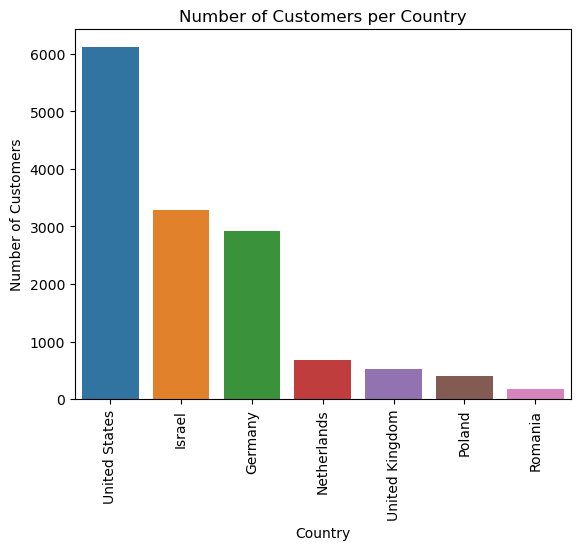

In [14]:
sns.barplot(data = customer_country, x = 'country_full', y = 'customer_email').set(title='Number of Customers per Country', xlabel='Country', ylabel='Number of Customers')
plt.xticks(rotation = 90)
plt.show;

**The majority of customers are in the United States with approximately half that amount of customers in Israel, the second ranked country by number of customers. This will be important to keep in mind to later get an idea of where the high value and returning customers mostly reside.**

#### What orderable_types and booking_product_types are customers ordering? What are the total order distribution counts for each type?

In [15]:
order_booking_types = filtered_df.groupby(['orderable_type', 'booking_product_type'])['order_id'].count().reset_index()

order_booking_types.sort_values('order_id', ascending=False, ignore_index=True)

,orderable_type,booking_product_type,order_id
0,Booking,entire_location,15388
1,Booking,meeting_room,3080
2,AddOn,access_add_on,2939
3,Booking,private_office,1251
4,AddOn,add_on,21


In [16]:
#Product and avg capacity

product_capacity = filtered_df[['orderable_type', 'booking_product_type', 'order_id', 'customer_email', 'capacity']].groupby(['orderable_type', 'booking_product_type']).agg({'order_id':'nunique', 
                                                                                                                                                                            'customer_email':'nunique',
                                                                                                                                                                            'capacity':'mean'}).reset_index()

product_capacity.sort_values('order_id', ascending=False, ignore_index=True)

,orderable_type,booking_product_type,order_id,customer_email,capacity
0,Booking,entire_location,15388,10500,1.000000
1,Booking,meeting_room,3080,1865,8.461364
2,AddOn,access_add_on,2939,1848,NaN
3,Booking,private_office,1251,752,13.417266
4,AddOn,add_on,21,18,NaN


#### What is the product basket customers are purchasing? What programmatic combinations of products are being ordered by customers?

In [18]:
#Without considering programmatic combinations, below is a SQL query that shows products each customer has purchased

product_basket_query = """
WITH mat_orders_CTE AS (
  SELECT 
    order_id, 
    partner_id AS operator_id, 
    partner_name AS operator_name, 
    status, 
    m.source, 
    fullname, 
    email AS customer_email, 
    company_name, 
    confirmation_id, 
    space_id, 
    space_name, 
    created_at, 
    promotion_code, 
    total_price AS final_price, 
    --not usd,  sub_total + tax_amount, sub_total=order_line_item_total_price
    ABS(discounted_amount) AS discounted_amount, 
    --not usd
    total_price_in_usd AS final_price_usd, 
    --amount transacted through Flexspace
    ABS(ROUND(
      discounted_amount * to_usd_rate, 2
    )) AS discounted_amount_usd, 
    ROUND(
      (
        total_price_in_usd + ABS(discounted_amount * to_usd_rate)
      ), 
      2
    ) AS original_price_usd, 
    processing_fee_in_usd, 
    to_usd_rate, 
    location_id, 
    location_name_en, 
    location_time_zone, 
    country, 
    m.state, 
    city, 
    order_line_item_id, 
    orderable_type, 
    orderable_id, 
    order_line_item_details, 
    access_id, 
    booking_product_type, 
    product_type_id, 
    add_on_days_to_expire, 
    capacity, 
    booking_id, 
    start_date, 
    end_date, 
    date, 
    quantity, 
    last_refresh 
  FROM 
    mat_orders AS m 
  WHERE created_at < '2023-07-01'
    AND status = 'paid' 
    AND email NOT IN (
      SELECT 
        email 
      FROM 
        mat_orders 
      WHERE 
        1 = 1 
        AND (
          company_name ILIKE '%%test%%'
          OR fullname ILIKE '%%test%%' 
          OR email ILIKE '%%test%%' 
          OR company_name ILIKE '%%test%%' 
          OR promotion_code ILIKE '%%test%%'
        )
    ) 
    AND m.source IN ('WL', 'FM')
    )
,
customer_products AS (
 SELECT customer_email, 
 booking_product_type, 
 CASE WHEN booking_product_type = 'entire_location' THEN COUNT(*) ELSE 0 END AS num_entire_location,
 CASE WHEN booking_product_type = 'meeting_room' THEN COUNT(*) ELSE 0 END AS num_meeting_room,
 CASE WHEN booking_product_type = 'access_add_on' THEN COUNT(*) ELSE 0 END AS num_access_add_on,
 CASE WHEN booking_product_type = 'private_office' THEN COUNT(*) ELSE 0 END AS num_private_office,
 CASE WHEN booking_product_type = 'add_on' THEN COUNT(*) ELSE 0 END AS num_add_on,
 COUNT(DISTINCT order_id) AS num_orders
 FROM mat_orders_CTE AS m
 GROUP BY 1, 2
 )
 ,

 product_basket AS (

 SELECT customer_email, 
 	STRING_AGG(DISTINCT booking_product_type, ', ') AS product_type_ordered,
 	COUNT(booking_product_type) AS num_product_type,
 	SUM(num_entire_location) AS total_entire_location,
 	SUM(num_meeting_room) AS total_meeting_room,
 	SUM(num_access_add_on) AS total_access_add_on,
 	SUM(num_private_office) AS total_private_office,
    SUM(num_add_on) AS total_add_on,
 	SUM(num_orders) AS total_orders
 FROM customer_products AS c
 GROUP BY 1
 ORDER BY 9 DESC)

 SELECT *
 FROM product_basket;"""

product_basket = pd.read_sql(product_basket_query, con=conn_string)

product_basket

,customer_email,product_type_ordered,num_product_type,total_entire_location,total_meeting_room,total_access_add_on,total_private_office,total_add_on,total_orders
0,sgrossman@augury.com,"entire_location, meeting_room, private_office",3,7.0,69.0,0.0,2.0,0.0,80.0
1,rob@studiowerc.com,entire_location,1,41.0,0.0,0.0,0.0,0.0,41.0
2,charlie@razroo.com,"entire_location, private_office",2,3.0,0.0,0.0,37.0,0.0,40.0
3,markm@opplab.com,"entire_location, meeting_room",2,2.0,35.0,0.0,0.0,0.0,37.0
4,jmalinowski@jurek.digital,entire_location,1,36.0,0.0,0.0,0.0,0.0,36.0
...,...,...,...,...,...,...,...,...,...
14063,Dolev@spartacargo.com,entire_location,1,1.0,0.0,0.0,0.0,0.0,1.0
14064,dolly.moorhead@mediportal.com,entire_location,1,1.0,0.0,0.0,0.0,0.0,1.0
14065,doloresaguerrevere@gmail.com,entire_location,1,1.0,0.0,0.0,0.0,0.0,1.0
14066,Baruchshaishbusiness@gmail.com,meeting_room,1,0.0,1.0,0.0,0.0,0.0,1.0


In [19]:
#Number of customers who ordered each product combination

product_basket.product_type_ordered.value_counts()

entire_location                                                 9707
meeting_room                                                    1650
access_add_on                                                   1243
private_office                                                   591
access_add_on, entire_location                                   525
entire_location, meeting_room                                    120
entire_location, private_office                                   88
meeting_room, private_office                                      29
access_add_on, entire_location, meeting_room                      27
access_add_on, meeting_room                                       24
access_add_on, private_office                                     15
access_add_on, entire_location, private_office                    15
entire_location, meeting_room, private_office                     12
add_on                                                            12
add_on, entire_location           

In [32]:
filtered_df['date'] = filtered_df['created_at'].dt.date
filtered_df['date'] = pd.to_datetime(filtered_df['date'])

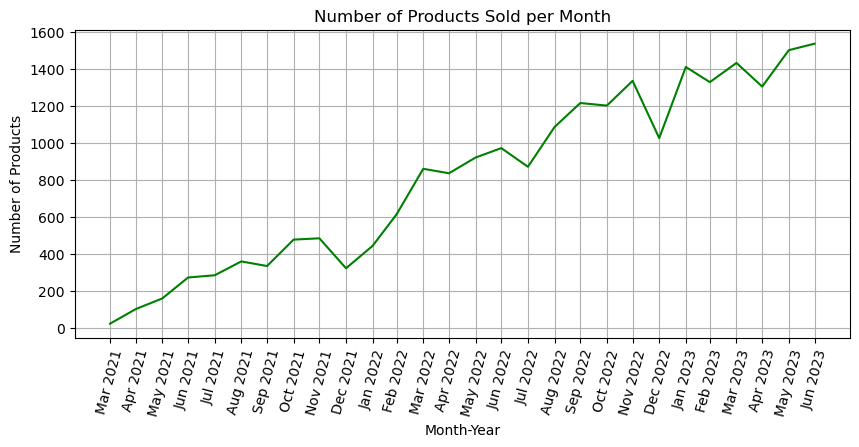

In [33]:
#First I want to see the general products sold over time

prod_over_time_df = pd.DataFrame(filtered_df.resample('M', on='date')['order_id'].count())
prod_over_time_df.columns = ['number_of_products_sold']
    
# plot prod_over_time_df
plt.figure(figsize=(10, 4))
sns.lineplot(x=prod_over_time_df.index, y=prod_over_time_df['number_of_products_sold'], color = 'green')

# Set the chart title and axis labels
plt.title('Number of Products Sold per Month')
plt.xlabel('Month-Year')
plt.ylabel('Number of Products')
plt.grid(True)


plt.xticks(prod_over_time_df.index, prod_over_time_df.index.strftime('%b %Y'), rotation=75)
plt.show()

In [34]:
#top products by orders placed

top_prod = product_basket.groupby('product_type_ordered')['total_orders'].sum().reset_index()

top_prod.sort_values('total_orders', ascending=False, ignore_index=True)

,product_type_ordered,total_orders
0,entire_location,13413.0
1,meeting_room,2521.0
2,"access_add_on, entire_location",2273.0
3,access_add_on,1794.0
4,private_office,864.0
5,"entire_location, meeting_room",557.0
6,"entire_location, private_office",344.0
7,"entire_location, meeting_room, private_office",227.0
8,"access_add_on, entire_location, meeting_room",179.0
9,"access_add_on, entire_location, private_office",166.0


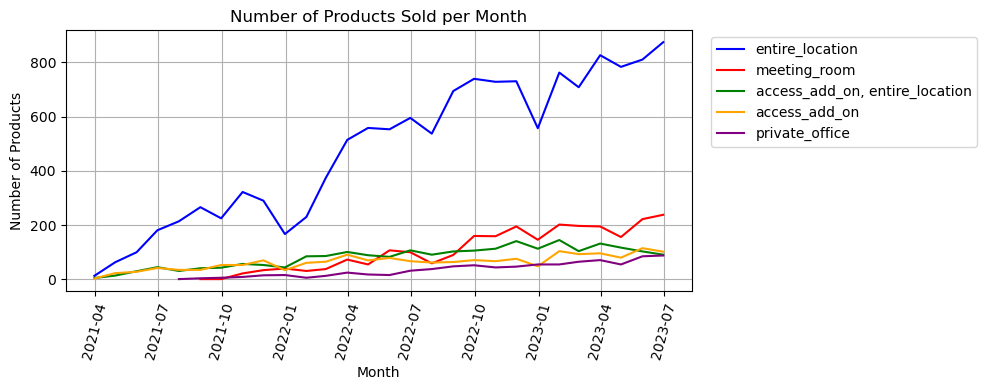

In [35]:
# entire_location_df = filtered_df[filtered_df['booking_product_type']=='entire_location']
# prod_basket_filtered = product_basket[product_basket['product_type_ordered'] == 'entire_location']

product_df = filtered_df.merge(product_basket, on='customer_email')

selected_product_types = ['entire_location', 'meeting_room', 'access_add_on, entire_location', 'access_add_on', 'private_office']
product_df = product_df[product_df['product_type_ordered'].isin(selected_product_types)]

  
    
product_df = product_df.groupby([pd.Grouper(key='date', freq='M'), 'product_type_ordered'])['order_id'].count().reset_index()
product_df.columns = ['Month', 'Product Type', 'Number of Orders']


plt.figure(figsize=(10, 4))

# Set the line colors for each product type
colors = ['blue', 'red', 'green', 'orange', 'purple']

# Iterate over each product type
for i, product_type in enumerate(selected_product_types):
    product_data = product_df[product_df['Product Type'] == product_type]
    sns.lineplot(x='Month', y='Number of Orders', data=product_data, color=colors[i], label=product_type)

# Set the chart title and axis labels
plt.title('Number of Products Sold per Month')
plt.xlabel('Month')
plt.ylabel('Number of Products')

# Set x-axis tick labels
plt.xticks(rotation=75)

# Add gridlines
plt.grid(True)

# Move the legend outside the chart
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()

plt.show()

**This distribution makes sense since the entire_location makes up the large majority of products. I will decide to stop my investigation of programmatic combinations of products here since entire_location is overwhelmingly ordered more than other products.**

**The top 3 products by customer were ordered on their own:**
1. entire_location
2. meeting_room
3. access_add_on

**The top 5 products by number of orders:**
1. entire_location
2. meeting_room
3. access_add_on, entire_location (customers that ordered these together over their lifetime)
4. access_add_on
5. private_office

**I will keep these in mind when looking into returning customers**

**Entire location is an entry ticket to have access to the entire space, private office is when a customer rents an office part of the space**

#### Customers over time

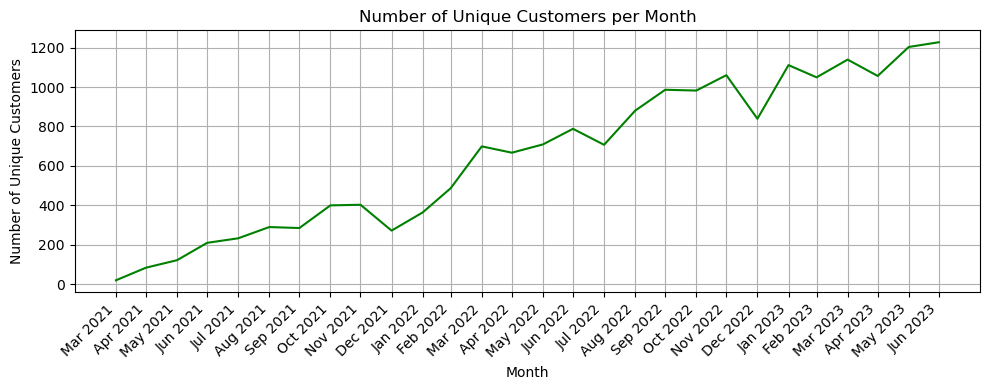

In [38]:
# Customers over time
cust_over_time_df = filtered_df.resample('M', on='date').customer_email.nunique()
cust_over_time_df = cust_over_time_df.reset_index()
cust_over_time_df.columns = ['Month', 'Number_of_unique_customers']

plt.figure(figsize=(10, 4))
sns.lineplot(x=cust_over_time_df['Month'], y=cust_over_time_df['Number_of_unique_customers'], color = 'Green')

# Set the chart title and axis labels
plt.title('Number of Unique Customers per Month')
plt.xlabel('Month')
plt.ylabel('Number of Unique Customers')
plt.xticks(cust_over_time_df['Month'], cust_over_time_df['Month'].dt.strftime('%b %Y'), rotation=45, ha='right')
plt.tight_layout()
plt.grid(True)
plt.show()

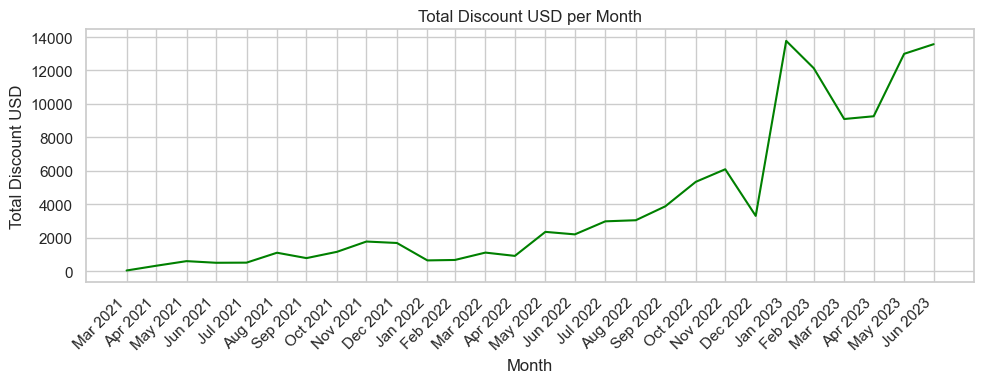

In [218]:
#Discounts Over Time

discount_over_time_df = filtered_df.resample('M', on='date').discounted_amount_usd.sum()
discount_over_time_df = discount_over_time_df.reset_index()
discount_over_time_df.columns = ['Month', 'total_discount_usd']
plt.figure(figsize=(10, 4))
sns.lineplot(x=discount_over_time_df['Month'], y=discount_over_time_df['total_discount_usd'], color = 'green')

# Set the chart title and axis labels
plt.title('Total Discount USD per Month')
plt.xlabel('Month')
plt.ylabel('Total Discount USD')
plt.xticks(discount_over_time_df['Month'], discount_over_time_df['Month'].dt.strftime('%b %Y'), rotation=45, ha='right')
plt.tight_layout()
plt.grid(True)
plt.show()

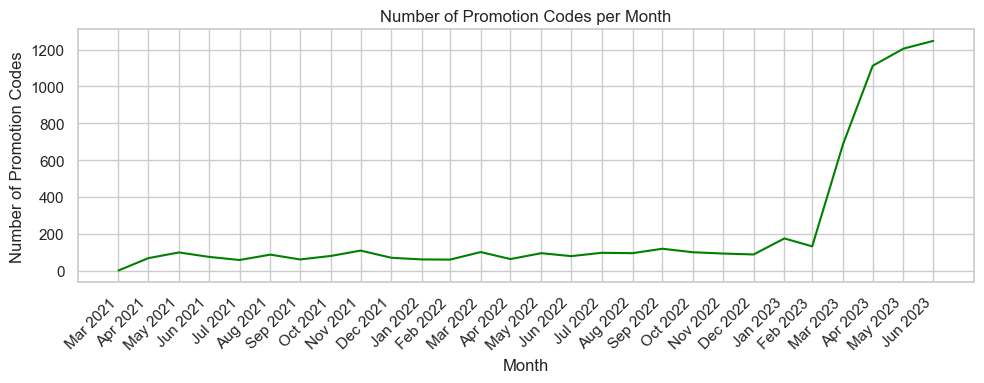

In [217]:
#Promo codes over time

promo_over_time_df = filtered_df.resample('M', on='date').promotion_code.count()
promo_over_time_df = promo_over_time_df.reset_index()
promo_over_time_df.columns = ['Month', 'number_of_promo_code']
plt.figure(figsize=(10, 4))
sns.lineplot(x=promo_over_time_df['Month'], y=promo_over_time_df['number_of_promo_code'], color = 'green')

# Set the chart title and axis labels
plt.title('Number of Promotion Codes per Month')
plt.xlabel('Month')
plt.ylabel('Number of Promotion Codes')
plt.xticks(promo_over_time_df['Month'], promo_over_time_df['Month'].dt.strftime('%b %Y'), rotation=45, ha='right')
plt.tight_layout()
plt.grid(True)
plt.show()

## Customer Deep-Dive

- RFM for customers and Employ the same process of cluttering
	1. Maximum transaction date for each customer (recency)
    2. Order count for each customer (frequency, counting 2 orders in the same day as 1)
    3. Sum of final price for each customer (monetary value) -- lifetime value per customer
    4. Lifetime of customer: last -first in days
    5. Average interval - lifetime in days/number of orders(frequency) 

    
    
- Second order analysis: returning customers, why did they return? Where did they return (location, space)? 
- Second Order Matrix: compare returning customer's first order to second order to see why returning? Discount? What is the interval between orders?

**For the RFM, I want to inlcude**
1. Current day - maximum transaction date for each customer (recency)
2. Order count for each customer (frequency, counting 2 orders in the same day as 1)
3. Sum of final price for each customer (monetary value)
4. Lifetime of customer: (last - first in days) + 1
5. Average interval - lifetime in days/number of orders(frequency) 


## RFM Creation Function

In [27]:
def create_rfm_for_customers(filtered_df):
    filtered_df['operator_full_name'] = filtered_df['operator_name']+"-"+filtered_df['country']+"-"+np.where(filtered_df['state'].isin([None]),"", filtered_df['state']+"-")+filtered_df['city']
    filtered_df['unique_operators'] = filtered_df[['operator_full_name', 'customer_email']].groupby('customer_email').nunique().sort_values('operator_full_name')
    filtered_df['date'] = filtered_df['created_at'].dt.date 
    rfm = filtered_df.groupby('customer_email').agg({"date":[min,  max, "nunique"],"final_price_usd":sum, "operator_full_name":"nunique", "operator_name":"nunique"})

    rfm.columns = [f"{x[0]}_{x[1]}" for x in rfm.columns]
    rfm = rfm.reset_index()
    
    rfm['lifetime'] = (rfm['date_max'] - rfm['date_min']).dt.days + 1
    rfm['recency'] = (pd.Timestamp('today').date() - rfm['date_max']).dt.days
    rfm = rfm.drop(['date_min', 'date_max'], axis=1).copy()
    rfm = rfm.rename({"date_nunique":"frequency",
                      "final_price_usd_sum":"monetary",
                      "operator_full_name_nunique": "number_of_unique_operators",
                     "operator_name_nunique": "number_of_unique_brands"}, axis=1).copy()
    rfm= rfm[rfm['number_of_unique_operators']>0].copy()
    
    sorted_date = filtered_df[['customer_email', 'date']].sort_values(by=['customer_email', 'date'], ascending=[True, True], ignore_index=True)
    sorted_date['previous_order'] = sorted_date.groupby(['customer_email'])['date'].shift()
    
    # From this, days between visits is simply the difference:
    sorted_date['interval_days'] = (sorted_date['date'] - sorted_date['previous_order']).dt.days
    sorted_date = sorted_date[sorted_date['interval_days']>0].copy()

    # Average days between visits:
    avg_interval_df = sorted_date.groupby('customer_email')['interval_days'].mean().reset_index()
    
    avg_interval_df.columns = ['customer_email', 'avg_interval_days']
    
    return rfm.merge(avg_interval_df, how='left')


In [28]:
rfm = create_rfm_for_customers(filtered_df)

In [29]:
rfm.head()


,customer_email,frequency,monetary,number_of_unique_operators,number_of_unique_brands,lifetime,recency,avg_interval_days
0,0488875@gmail.com,3,76.21,1,1,20,61,9.5
1,0524235148si@gmail.com,1,40.85,1,1,1,223,NaN
2,052kozoz@gmail.com,3,132.84,2,2,57,171,28.0
3,0584854855yos@gmail.com,1,120.08,1,1,1,208,NaN
4,0585171281@proton.me,1,30.90,1,1,1,391,NaN


In [46]:
filtered_df.head()

,order_id,operator_id,operator_name,status,source,fullname,customer_email,company_name,confirmation_id,space_id,space_name,created_at,promotion_code,final_price,discounted_amount,final_price_usd,discounted_amount_usd,original_price_usd,processing_fee_in_usd,to_usd_rate,location_id,location_name_en,location_time_zone,country,state,city,order_line_item_id,orderable_type,orderable_id,order_line_item_details,booking_product_type,product_type_id,add_on_days_to_expire,capacity,booking_id,start_date,end_date,date,quantity,last_refresh,company_name_lower,country_full,operator_full_name,unique_operators
0,041cac62-1867-453e-a5ea-5d80a54ab149,7041dd96-032c-4284-bb6f-cd48f207b956,Mindspace,paid,WL,Segah Meer,segah@keetro.net,Keetro Labs,754008a9,62e8d0bd-d025-485a-a836-02adf6d32ccd,Mindspace Daily - Ha’Bursa,2021-06-02 05:20:12.325725,SPECIAL521,1067.04,48.0,325.97,14.66,340.63,9.75,0.305490,aae68b56-d19a-4b68-a795-1047ca8748a2,Ramat Gan - Ha’Bursa,Asia/Jerusalem,IL,None,Ramat Gan,359640c3-fa2b-4210-8254-dd67955f9ab5,AddOn,3a05162a-c2c2-47fd-91d0-b1ac10d43144,{'space_id': '62e8d0bd-d025-485a-a836-02adf6d3...,access_add_on,1986c53d-96a1-4394-8012-a993b46f6e43,60.0,NaN,None,None,None,2021-06-02,1.0,2023-07-23 21:15:00.231227+00:00,keetro labs,Israel,Mindspace-IL-Ramat Gan,NaN
1,c437542e-7369-4f57-9634-d3d8c906049d,7041dd96-032c-4284-bb6f-cd48f207b956,Mindspace,paid,WL,Mark Bosshard,mark.bosshard1@gmail.com,ipt,163b482a,eb3f2ab3-a890-452e-aae9-099e49454f2f,Mindspace Daily - Dam,2021-11-26 08:11:23.629412,None,30.25,0.0,33.57,0.00,33.57,1.61,1.109830,76fdc9f9-777d-401b-bf05-f1f81c27933a,Amsterdam - Dam,Europe/Amsterdam,NL,None,Amsterdam,afc68bc2-cba4-4229-aa52-eff96dffee1b,Booking,1c23a107-65a9-453a-8367-5e7d81b6f772,"{'days': 1, 'time': None, 'end_date': '2021-11...",entire_location,bef677a6-5596-4ca0-a31e-ea2eccb5e959,NaN,1.0,1c23a107-65a9-453a-8367-5e7d81b6f772,2021-11-26,2021-11-26,2021-11-26,1.0,2023-07-23 21:15:00.231227+00:00,ipt,Netherlands,Mindspace-NL-Amsterdam,NaN
2,9906ceef-5ac6-411c-ac3f-bdc88494f7fd,b6bfa6e9-e780-4b7c-af83-39a63380a709,WeWork Israel,paid,WL,Justin Rohloff,justin@rohloffgroup.co.za,Rohloff,6abd5552,0f197ecc-570f-4bed-b382-9a2b717ce533,Open Workspace Day Pass,2021-11-15 07:18:18.568518,None,374.40,0.0,120.69,0.00,120.69,0.00,0.322369,b2ee7ec8-5c3d-4768-9c47-64fd57d79cc7,WeWork Jerusalem,Asia/Jerusalem,IL,None,Jerusalem,ca946768-159d-41b6-9cd6-c2d9440f7c72,AddOn,afd158c3-900d-482b-b91f-193b25e7963a,{'space_id': '0f197ecc-570f-4bed-b382-9a2b717c...,access_add_on,e1b38119-616d-4a17-8dd0-3458369ca4e8,90.0,NaN,None,None,None,2021-11-15,1.0,2023-07-23 21:15:00.231227+00:00,rohloff,Israel,WeWork Israel-IL-Jerusalem,NaN
3,f2da7ed7-00cd-4d85-85b3-a5121fd28202,7041dd96-032c-4284-bb6f-cd48f207b956,Mindspace,paid,WL,Andrei Marcut,andrei@creativegluelab.com,Creative Glue Lab GmbH,4e5e9d5c,138b7e56-61c1-4e9a-9a56-84bae539f131,Mindspace Daily - Uhlandstraße 32 (Ku'damm),2023-04-11 07:40:12.034568,,104.72,0.0,112.69,0.00,112.69,4.69,1.076110,855fa3e4-8382-4fbc-b2f9-d9b0f9a20f57,Berlin - Ku’damm,Europe/Berlin,DE,None,Berlin,a0a9fbae-2575-4e73-b7d6-ec923ad8bfff,AddOn,d2adbe4e-aa1e-484e-af40-60f3fe3abfa8,{'space_id': '138b7e56-61c1-4e9a-9a56-84bae539...,access_add_on,1986c53d-96a1-4394-8012-a993b46f6e43,30.0,NaN,None,None,None,2023-04-11,1.0,2023-07-23 21:15:00.231227+00:00,creative glue lab gmbh,Germany,Mindspace-DE-Berlin,NaN
4,f076ff1f-38d4-45b0-b11c-5113e980d63e,d0db8780-54e4-41c2-b93c-56db16bf4d56,Werqwise,paid,WL,Alyssa Lammers,alammers@acerelocation.com,Ace Relocation Systems,de14b36f,3149a46e-d508-475d-8343-421030c99354,Lounge Day Pass,2022-06-20 21:00:18.986207,None,45.00,0.0,45.00,0.00,45.00,1.61,1.000000,1e7217b4-ea52-4a54-a55c-6262641282ff,Werqwise San Francisco,America/Los_Angeles,US,CA,San Francisco,c9141477-65e1-4feb-8417-f3e38a45c039,Booking,15e95d1c-c769-46f0-a54f-02a430bd1b8f,"{'days': 1, 'time': None, 'daily': {'time': No...",entire_location,537ed05a-5508-4e97-aac4-6f01e692ac59,NaN,1.0,15e95d1c-c769-46f0-a54f-02a

## First and Second Order Analysis

### Dataframe creation


**I will get the first and second order data for each customer. This will be added and then used to inspect the customers face-value:**
- How long does it take for customers to order a second time?
- On average, how long does it take customer to order (avg interval between first and second order)
- For customers with 2, 3, 4, and 5+ orders, what is the distribution of days between first and second order? Avg interval days?
    - Can also look at the same for recency and monetary value

In [221]:
rfm_copy = rfm.copy()

In [222]:
#To join other metrics, I want to pull them from filtered_df 
additional_metrics =  filtered_df.loc[:, ['customer_email', 
                                          'operator_name',
                                          'operator_full_name',
                                          'country',
                                          'state',
                                          'city',
                                          'space_name',
                                          'created_at',
                                          'promotion_code',
                                          'final_price_usd',
                                          'discounted_amount_usd',
                                          'booking_product_type',
                                          'quantity'
                                        ]]

#additional_metrics['created_at'] = additional_metrics.created_at.dt.date


additional_metrics = additional_metrics.sort_values(by=['customer_email', 'created_at'])

**First Order Dataframe**

In [223]:
first_order_df = additional_metrics.groupby('customer_email').first().reset_index()
first_order_df.rename(columns={'operator_name':'fo_operator_name',
                               'operator_full_name':'fo_operator_full_name',
                               'country':'fo_country',
                               'state':'fo_state',
                               'city':'fo_city',
                               'space_name':'fo_space_name',
                               'created_at': 'first_order_date',
                               'discounted_amount_usd':'first_order_discount',
                               'promotion_code':'first_order_promo_code',
                               'final_price_usd':'first_order_price_usd',
                               'booking_product_type':'fo_booking_product_type',
                               'quantity':'fo_quantity'
                               }, inplace=True)

first_order_df['first_order_date'] = first_order_df['first_order_date'].dt.date

first_order_df.shape

(14064, 13)

In [224]:
additional_metrics['created_at'] = additional_metrics['created_at'].dt.date


**Second Order Dataframe**

In [225]:
additional_metrics_unique = additional_metrics.drop_duplicates(subset=['customer_email', 'created_at']).copy()


additional_metrics_unique['rank'] = additional_metrics_unique.groupby('customer_email')['created_at'].rank(method='first')

second_order_df = additional_metrics_unique[additional_metrics_unique['rank'] == 2].copy()

second_order_df.drop('rank', axis=1, inplace=True)

second_order_df.rename(columns={'created_at': 'second_order_date',
                               'discounted_amount_usd':'second_order_discount',
                               'promotion_code':'second_order_promo_code',
                               'final_price_usd':'so_final_price_usd',
                               'operator_name':'so_operator_name',
                               'operator_full_name':'so_operator_full_name',
                               'country':'so_country',
                               'state':'so_state',
                               'city':'so_city',
                               'space_name':'so_space_name',
                               'booking_product_type':'so_booking_product_type',
                               'quantity':'so_quantity'
                               }, inplace=True)

# second_order_df.dropna(subset=['customer_email'], inplace=True)

second_order_df.shape

(3169, 13)

**Merge with rfm_copy**

In [226]:
rfm_fso_df = rfm_copy.merge(first_order_df, on='customer_email', how='left')
rfm_fso_df = rfm_fso_df.merge(second_order_df, on='customer_email', how='left')

rfm_fso_df.shape

(14062, 32)

In [227]:
rfm_fso_df['days_between_1st_2nd_order'] = (rfm_fso_df['second_order_date'] - rfm_fso_df['first_order_date']).dt.days


In [228]:
rfm_fso_df.head()

,customer_email,frequency,monetary,number_of_unique_operators,number_of_unique_brands,lifetime,recency,avg_interval_days,fo_operator_name,fo_operator_full_name,fo_country,fo_state,fo_city,fo_space_name,first_order_date,first_order_promo_code,first_order_price_usd,first_order_discount,fo_booking_product_type,fo_quantity,so_operator_name,so_operator_full_name,so_country,so_state,so_city,so_space_name,second_order_date,second_order_promo_code,so_final_price_usd,second_order_discount,so_booking_product_type,so_quantity,days_between_1st_2nd_order
0,0488875@gmail.com,3,76.21,1,1,20,61,9.5,Urban Place,Urban Place-IL-Tel Aviv,IL,None,Tel Aviv,UP Day Pass,2023-05-04,,25.48,0.0,entire_location,1.0,Urban Place,Urban Place-IL-Tel Aviv,IL,None,Tel Aviv,UP Day Pass,2023-05-18,,25.41,0.0,entire_location,1.0,14.0
1,0524235148si@gmail.com,1,40.85,1,1,1,223,NaN,WeWork Israel,WeWork Israel-IL-Ramat Gan,IL,None,Ramat Gan,Open Workspace Day Pass,2022-12-12,None,40.85,0.0,entire_location,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,052kozoz@gmail.com,3,132.84,2,2,57,171,28.0,Urban Place,Urban Place-IL-Jerusalem,IL,None,Jerusalem,UP Office Day Pass - 1p,2022-12-08,None,50.59,0.0,private_office,1.0,Urban Place,Urban Place-IL-Jerusalem,IL,None,Jerusalem,UP Office Day Pass - 1p,2023-01-26,None,51.42,0.0,private_office,1.0,49.0
3,0584854855yos@gmail.com,1,120.08,1,1,1,208,NaN,WeWork Israel,WeWork Israel-IL-Jerusalem,IL,None,Jerusalem,Meeting Room 2B,2022-12-27,None,120.08,0.0,meeting_room,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0585171281@proton.me,1,30.90,1,1,1,391,NaN,WeWork Israel,WeWork Israel-IL-Haifa,IL,None,Haifa,Open Workspace Day Pass,2022-06-27,None,30.90,0.0,entire_location,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [247]:
rfm_fso_df_copy = rfm_fso_df.copy()

rfm_fso_df_copy['second_order_date_ts'] = pd.to_datetime(rfm_fso_df_copy['second_order_date'])
rfm_fso_df_copy['first_order_date_ts'] = pd.to_datetime(rfm_fso_df_copy['first_order_date'])



In [248]:
rfm_fso_df_copy = rfm_fso_df_copy[(rfm_fso_df_copy['lifetime'] > 1)]

### Number of First and Second Orders Over Time

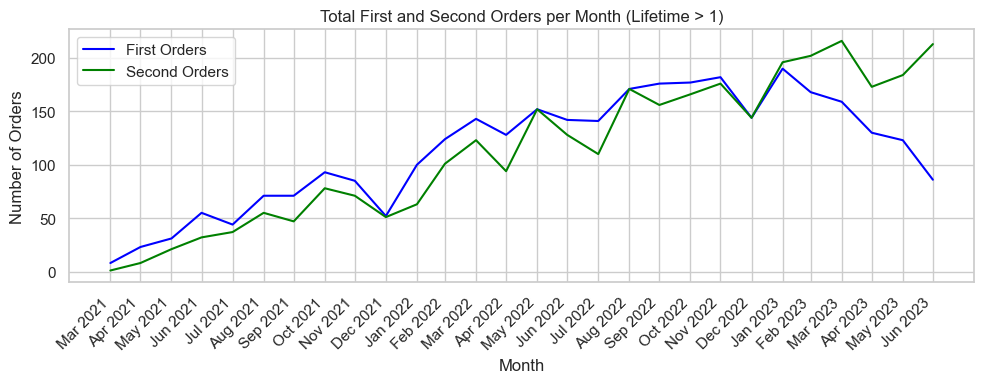

In [249]:
#Orders Over Time

orders_over_time_df1 = rfm_fso_df_copy.resample('M', on='first_order_date_ts').first_order_date.count()
orders_over_time_df1 = orders_over_time_df1.reset_index()
orders_over_time_df1.columns = ['Month', 'number_of_first_orders']


orders_over_time_df2 = rfm_fso_df_copy.resample('M', on='second_order_date_ts').second_order_date.count()
orders_over_time_df2 = orders_over_time_df2.reset_index()
orders_over_time_df2.columns = ['Month', 'number_of_second_orders']



plt.figure(figsize=(10, 4))
sns.lineplot(x=orders_over_time_df1['Month'], y=orders_over_time_df1['number_of_first_orders'], color='Blue', label='First Orders')
sns.lineplot(x=orders_over_time_df2['Month'], y=orders_over_time_df2['number_of_second_orders'], color = 'Green', label='Second Orders')

# Set the chart title and axis labels
plt.title('Total First and Second Orders per Month (Lifetime > 1)')
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.xticks(orders_over_time_df2['Month'], orders_over_time_df2['Month'].dt.strftime('%b %Y'), rotation=45, ha='right')
plt.tight_layout()
plt.legend()
plt.show()

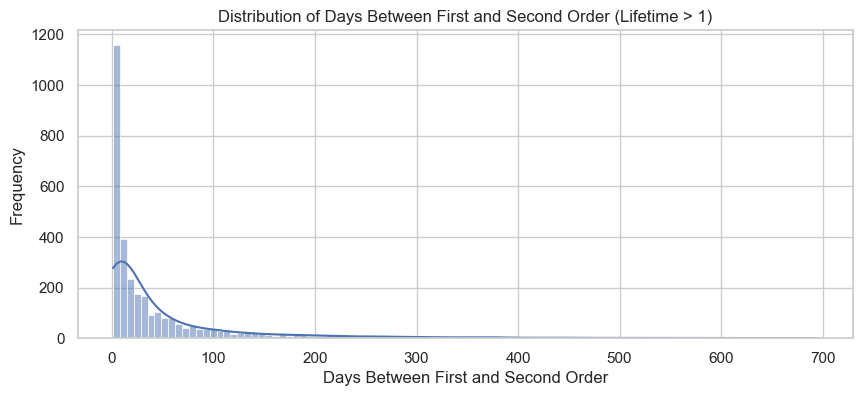

In [250]:
plt.figure(figsize=(10, 4))
sns.histplot(rfm_fso_df_copy['days_between_1st_2nd_order'], kde=True)
plt.xlabel('Days Between First and Second Order')
plt.ylabel('Frequency')
plt.title('Distribution of Days Between First and Second Order (Lifetime > 1)')
plt.show()

**Average Interval between orders - general**

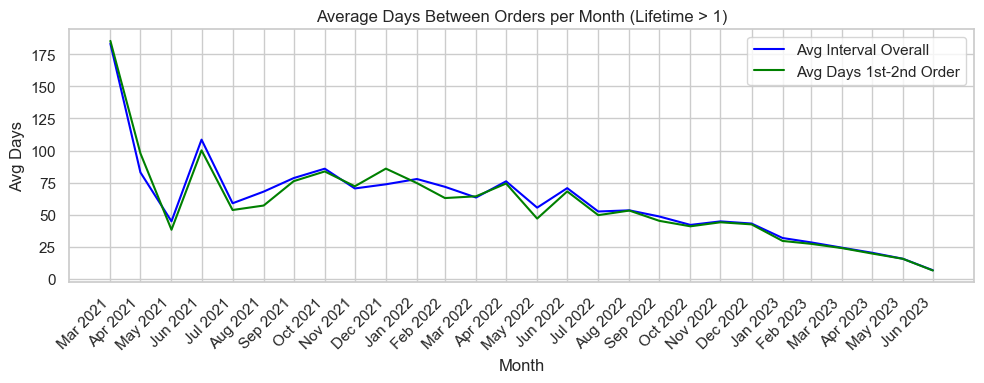

In [251]:
#How does avg interval between orders change over time

int_over_time_df = rfm_fso_df_copy.resample('M', on='first_order_date_ts').avg_interval_days.mean()
int_over_time_df = int_over_time_df.reset_index()
int_over_time_df.columns = ['Month', 'avg_interval_days']

days_between_over_time_df = rfm_fso_df_copy.resample('M', on='first_order_date_ts').days_between_1st_2nd_order.mean()
days_between_over_time_df = days_between_over_time_df.reset_index()
days_between_over_time_df.columns = ['Month', 'days_between_1st_2nd_order']


plt.figure(figsize=(10, 4))
# sns.lineplot(x=discount_over_time_df1['Month'], y=discount_over_time_df1['total_discount_usd'], color='Blue', label='First Orders')
sns.lineplot(x=int_over_time_df['Month'], y=int_over_time_df['avg_interval_days'], color = 'blue', label='Avg Interval Overall')
sns.lineplot(x=days_between_over_time_df['Month'], y=days_between_over_time_df['days_between_1st_2nd_order'], color = 'Green', label='Avg Days 1st-2nd Order')


# Set the chart title and axis labels
plt.title('Average Days Between Orders per Month (Lifetime > 1)')
plt.xlabel('Month')
plt.ylabel('Avg Days')
plt.xticks(int_over_time_df['Month'], int_over_time_df['Month'].dt.strftime('%b %Y'), rotation=45, ha='right')
plt.tight_layout()
#plt.legend()
plt.show()

**Average Final Price**

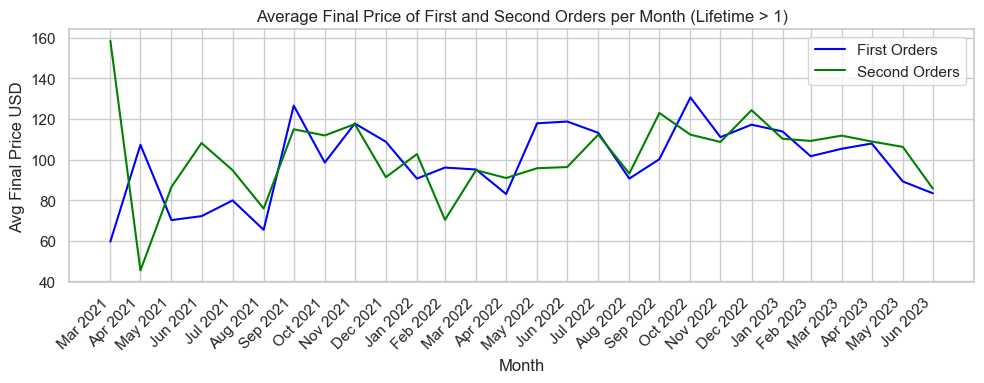

In [257]:
#avg monetary first and second orders over time

monetary_over_time_df1 = rfm_fso_df_copy.resample('M', on='first_order_date_ts').first_order_price_usd.mean()
monetary_over_time_df1 = monetary_over_time_df1.reset_index()
monetary_over_time_df1.columns = ['Month', 'first_order_price_usd']

monetary_over_time_df2 = rfm_fso_df_copy.resample('M', on='second_order_date_ts').so_final_price_usd.mean()
monetary_over_time_df2 = monetary_over_time_df2.reset_index()
monetary_over_time_df2.columns = ['Month', 'so_final_price_usd']

plt.figure(figsize=(10, 4))
sns.lineplot(x=monetary_over_time_df1['Month'], y=monetary_over_time_df1['first_order_price_usd'], color='Blue', label='First Orders')
sns.lineplot(x=monetary_over_time_df2['Month'], y=monetary_over_time_df2['so_final_price_usd'], color = 'Green', label='Second Orders')

# Set the chart title and axis labels
plt.title('Average Final Price of First and Second Orders per Month (Lifetime > 1)')
plt.xlabel('Month')
plt.ylabel('Avg Final Price USD')
plt.xticks(monetary_over_time_df2['Month'], monetary_over_time_df2['Month'].dt.strftime('%b %Y'), rotation=45, ha='right')
plt.tight_layout()
plt.legend()
plt.show();

**Total Monetary Value**

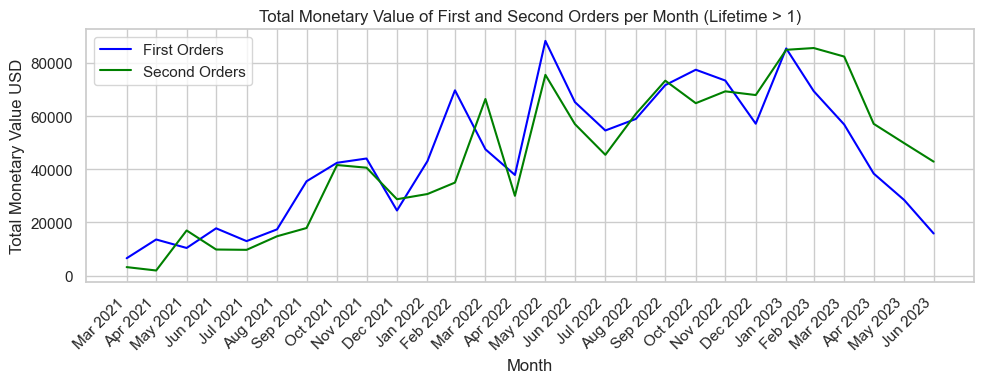

In [258]:
#Avg Monetary value for first and second orders

monetary_over_time_df1 = rfm_fso_df_copy.resample('M', on='first_order_date_ts').monetary.sum()
monetary_over_time_df1 = monetary_over_time_df1.reset_index()
monetary_over_time_df1.columns = ['Month', 'first_order_price_usd']

monetary_over_time_df2 = rfm_fso_df_copy.resample('M', on='second_order_date_ts').monetary.sum()
monetary_over_time_df2 = monetary_over_time_df2.reset_index()
monetary_over_time_df2.columns = ['Month', 'so_final_price_usd']


plt.figure(figsize=(10, 4))
sns.lineplot(x=monetary_over_time_df1['Month'], y=monetary_over_time_df1['first_order_price_usd'], color='Blue', label='First Orders')
sns.lineplot(x=monetary_over_time_df2['Month'], y=monetary_over_time_df2['so_final_price_usd'], color = 'Green', label='Second Orders')

# Set the chart title and axis labels
plt.title('Total Monetary Value of First and Second Orders per Month (Lifetime > 1)')
plt.xlabel('Month')
plt.ylabel('Total Monetary Value USD')
plt.xticks(monetary_over_time_df2['Month'], monetary_over_time_df2['Month'].dt.strftime('%b %Y'), rotation=45, ha='right')
plt.tight_layout()
plt.legend()
plt.show()

**Average Monetary Value**

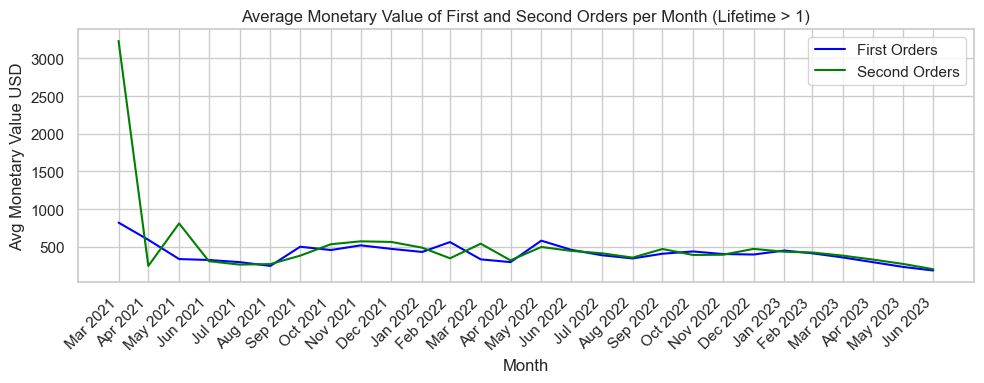

In [259]:
#Avg Monetary value for first and second orders

monetary_over_time_df1 = rfm_fso_df_copy.resample('M', on='first_order_date_ts').monetary.mean()
monetary_over_time_df1 = monetary_over_time_df1.reset_index()
monetary_over_time_df1.columns = ['Month', 'first_order_price_usd']

monetary_over_time_df2 = rfm_fso_df_copy.resample('M', on='second_order_date_ts').monetary.mean()
monetary_over_time_df2 = monetary_over_time_df2.reset_index()
monetary_over_time_df2.columns = ['Month', 'so_final_price_usd']


plt.figure(figsize=(10, 4))
sns.lineplot(x=monetary_over_time_df1['Month'], y=monetary_over_time_df1['first_order_price_usd'], color='Blue', label='First Orders')
sns.lineplot(x=monetary_over_time_df2['Month'], y=monetary_over_time_df2['so_final_price_usd'], color = 'Green', label='Second Orders')

# Set the chart title and axis labels
plt.title('Average Monetary Value of First and Second Orders per Month (Lifetime > 1)')
plt.xlabel('Month')
plt.ylabel('Avg Monetary Value USD')
plt.xticks(monetary_over_time_df2['Month'], monetary_over_time_df2['Month'].dt.strftime('%b %Y'), rotation=45, ha='right')
plt.tight_layout()
plt.legend()
plt.show()

## Promo Code Analysis: Jan 2023 - Jun 2023

In [79]:
def promo_analysis(df_, key='operator_name'):
    # Filter by date
    df_promo = df_[(df_['date'] < pd.to_datetime('2023-07-01')) & (filtered_df['date'] >= pd.to_datetime('2023-01-01'))]
    
    # Filter out null values for promotion_code
    df_promo = df_promo[df_promo['promotion_code'].notnull()].reset_index()
    
    # Group by 'key' (default is 'operator_name') and 'promotion_code', then count the occurrences
    result = df_promo.groupby([key, 'promotion_code']).size().reset_index(name='count')
    result.columns = ('operator', 'promotion code', 'count')
    
    # Find promo codes used before 2023-01-01
    promo_codes_before_2023 = df_[df_['date'] < pd.to_datetime('2023-01-01')]['promotion_code'].unique()
    
    # Filter out promo codes used before 2023-01-01
    df_promo = df_promo[~df_promo['promotion_code'].isin(promo_codes_before_2023)].reset_index(drop=True)
    
    return df_promo
#     return result



# result_df_by_operator_name = promo_analysis(filtered_df)
# result_df_by_full_name = promo_analysis(filtered_df, key="operator_full_name")
# indices_to_drop = result_df_by_full_name[result_df_by_full_name['promotion code'] == ''].index
# result_df_by_full_name.drop(indices_to_drop, inplace=True)
# result_df_by_full_name = result_df_by_full_name.sort_values(by='count', ascending=False)



In [80]:
promo_df = promo_analysis(filtered_df)

In [163]:
promo_df['promotion_code'] = promo_df['promotion_code'].str.upper() 


#### Investigate Promo Codes during the New Feature Release

- Who are the operators that used that
- what are the most used codes (over time)
- heatmap - x axis the month, y axis the operators - but feel free to do what works for you

In [180]:
# Operators that used the feature

operators_promo = promo_df.groupby('operator_name')['promotion_code'].count().reset_index()

operators_promo = operators_promo.sort_values('promotion_code', ascending=False)

operators_promo

,operator_name,promotion_code
4,WeWork Israel,323
2,Mindspace,88
3,ROOMS,34
5,Werqwise,12
6,gSpace,5
1,Luminary,2
0,Bond Collective,1


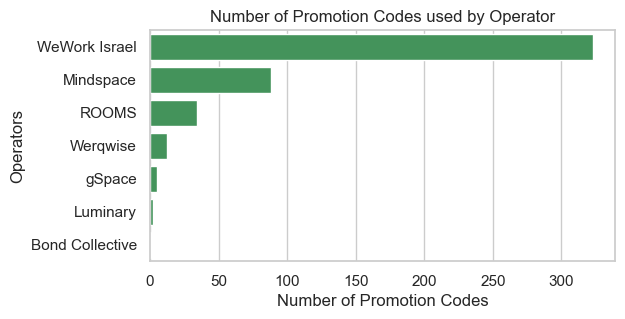

In [181]:
plt.figure(figsize = (6, 3))

sns.set(style="whitegrid", color_codes=True)

pal = sns.color_palette("Greens_d", 1)

sns.barplot(y = operators_promo['operator_name'], x = operators_promo['promotion_code'], palette= pal)

plt.xlabel('Number of Promotion Codes')
plt.ylabel('Operators')
plt.title('Number of Promotion Codes used by Operator');

In [182]:
# Operators_full_name that used the feature

operators_full_promo = promo_df.groupby(['operator_full_name', 'operator_name'])['promotion_code'].count().reset_index()

operators_full_promo = operators_full_promo.sort_values('promotion_code', ascending=False, ignore_index=True)

operators_full_promo

,operator_full_name,operator_name,promotion_code
0,WeWork Israel-IL-Tel Aviv,WeWork Israel,265
1,Mindspace-DE-Berlin,Mindspace,33
2,WeWork Israel-IL-Herzliya,WeWork Israel,21
3,Mindspace-DE-Munich,Mindspace,15
4,WeWork Israel-IL-Jerusalem,WeWork Israel,14
5,ROOMS-IL-Tel Aviv,ROOMS,13
6,ROOMS-IL-Petah Tikva,ROOMS,13
7,WeWork Israel-IL-Ramat Gan,WeWork Israel,13
8,Werqwise-US-CA-San Francisco,Werqwise,12
9,WeWork Israel-IL-Haifa,WeWork Israel,9


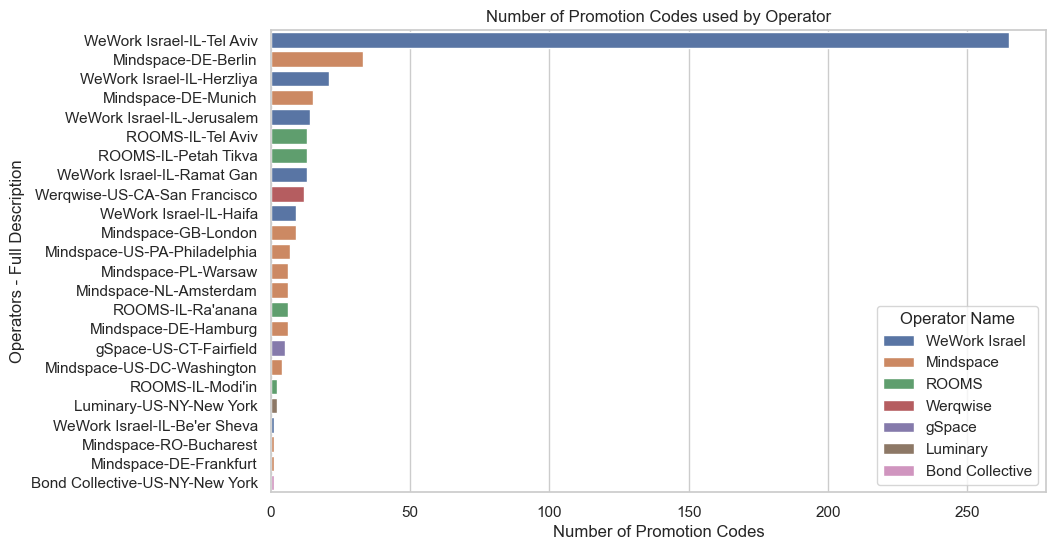

In [183]:
plt.figure(figsize = (10, 6))

sns.set(style="whitegrid", color_codes=True)

pal = sns.color_palette("Greens_d", 1)

sns.barplot(y = operators_full_promo['operator_full_name'], x = operators_full_promo['promotion_code'], hue=operators_full_promo['operator_name'], dodge=False)

plt.xlabel('Number of Promotion Codes')
plt.ylabel('Operators - Full Description')
plt.legend(title='Operator Name',loc='lower right')  

plt.title('Number of Promotion Codes used by Operator');

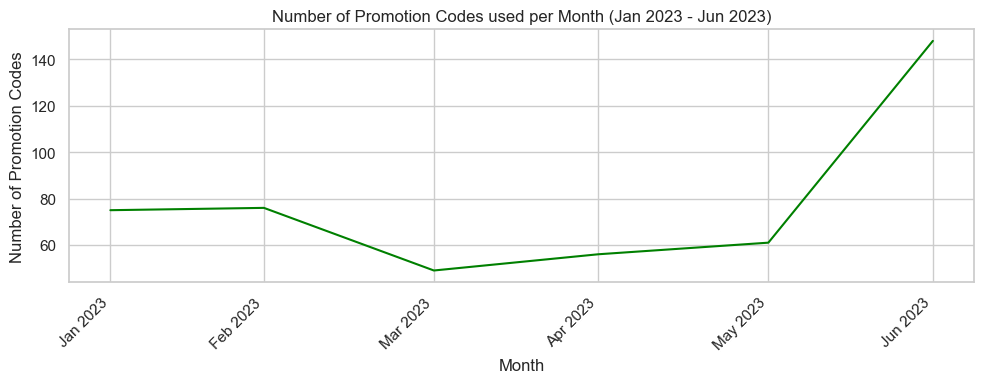

In [184]:
#Promo codes used over time

new_promos_over_time_df = promo_df.resample('M', on='date').promotion_code.count()
new_promos_over_time_df = new_promos_over_time_df.reset_index()
new_promos_over_time_df.columns = ['Month', 'num_promo_code']

plt.figure(figsize=(10, 4))
sns.lineplot(x=new_promos_over_time_df['Month'], y=new_promos_over_time_df['num_promo_code'], color = 'Green')

# Set the chart title and axis labels
plt.title('Number of Promotion Codes used per Month (Jan 2023 - Jun 2023)')
plt.xlabel('Month')
plt.ylabel('Number of Promotion Codes')
plt.xticks(new_promos_over_time_df['Month'], new_promos_over_time_df['Month'].dt.strftime('%b %Y'), rotation=45, ha='right')
plt.tight_layout()
plt.grid(True)
plt.show()

In [185]:
#Most used Promo codes during this time period

promo_count = promo_df.loc[:, ['promotion_code', 'operator_name', 'order_id', 'date']]

# promo_count['promotion_code'] = promo_count['promotion_code'].str.upper() 

promo_count = promo_count.groupby(['promotion_code', 'operator_name'])['order_id'].count().reset_index()

promo_count = promo_count.sort_values('order_id', ascending=False, ignore_index=True)

promo_count = promo_count.head(10)

promo_count

,promotion_code,operator_name,order_id
0,AZRIELI50,WeWork Israel,113
1,PRIDE2023,Mindspace,85
2,SHAULHAMELECH50,WeWork Israel,35
3,ROOMS50,ROOMS,34
4,WEWORK25,WeWork Israel,31
5,NETA,WeWork Israel,22
6,WEWORK50,WeWork Israel,16
7,AZRIELITOWN20,WeWork Israel,9
8,DANNY15,Werqwise,6
9,ANDREA15,Werqwise,4


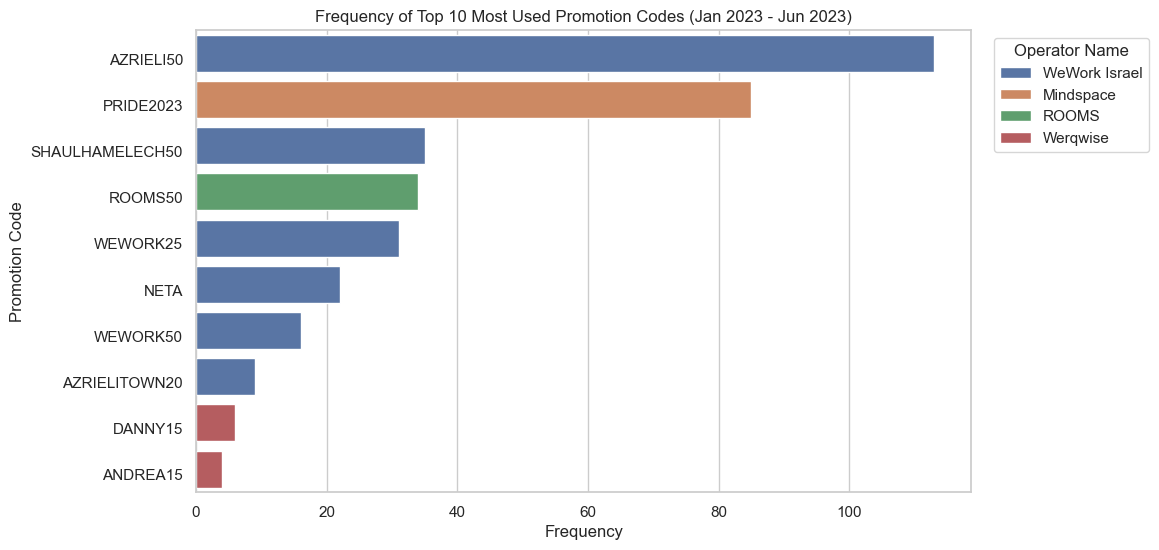

In [186]:
plt.figure(figsize = (10, 6))

sns.set(style="whitegrid", color_codes=True)

pal = sns.color_palette("Greens_d", 1)

sns.barplot(y = promo_count['promotion_code'], x = promo_count['order_id'], hue=promo_count['operator_name'], dodge=False)

plt.xlabel('Frequency')
plt.ylabel('Promotion Code')
plt.yticks(va='top')
plt.legend(title='Operator Name',bbox_to_anchor=(1.02, 1), loc='upper left')  

plt.title('Frequency of Top 10 Most Used Promotion Codes (Jan 2023 - Jun 2023)');

- heatmap - x axis the month, y axis the operators - but feel free to do what works for you


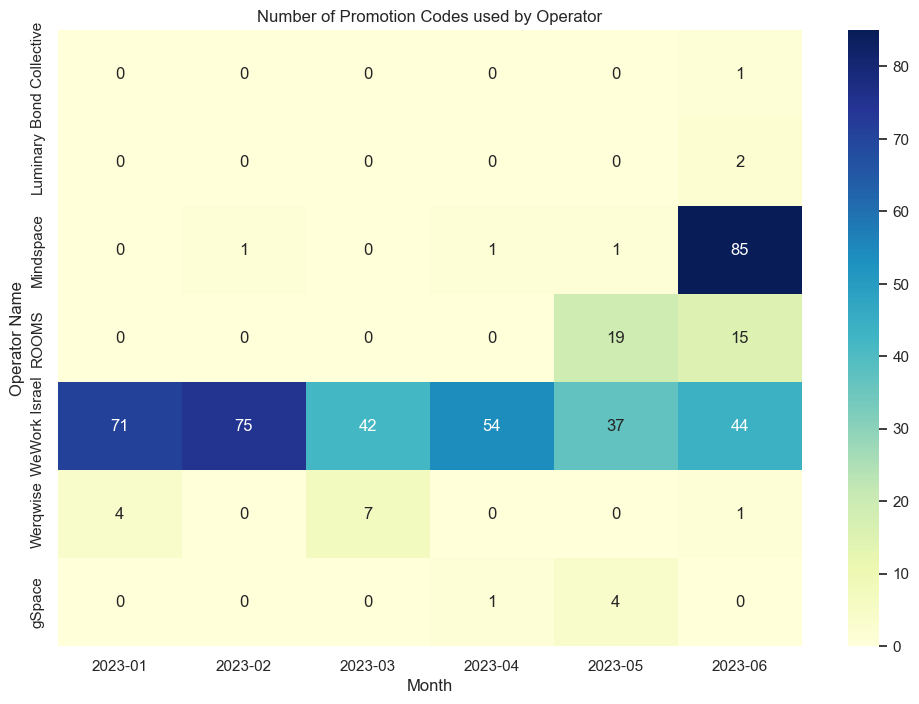

In [216]:

# Group by 'operator_name' and 'Month', then count the occurrences of 'promotion_code'
#heatmap_data = promo_df.groupby(['operator_name', 'Month'])['promotion_code'].count().reset_index()
heatmap_data = promo_df.groupby('operator_name').resample('M', on='date').promotion_code.count()
heatmap_data = heatmap_data.reset_index()
heatmap_data.columns = ['operator_name', 'Month', 'num_promo_code']
heatmap_data = heatmap_data.sort_values('Month')

heatmap_data['Month'] = heatmap_data['Month'].dt.to_period('M')



# Pivot the data to create a pivot table with 'operator_name' as rows, 'Month' as columns, and counts as values
heatmap_pivot = heatmap_data.pivot_table(index='operator_name', columns='Month', values='num_promo_code', fill_value=0)

# Sort the pivot table by operator_name
# heatmap_pivot = heatmap_pivot.sort_index()

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_pivot, annot=True, fmt='d', cmap='YlGnBu')

# Set plot labels and title
plt.xlabel('Month')
plt.ylabel('Operator Name')
plt.xticks(rotation=0)
plt.yticks(rotation=90)

plt.title('Number of Promotion Codes used by Operator');

